In [64]:
import tensorflow as tf
from pathlib import Path
from PIL import Image
import numpy as np
import os

In [85]:
# Create the dataset
data_dir = Path('./dataset/mudkip/')

img_height = 200
img_width = 200

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed = 258, # mudkips pokedex number
    image_size=(img_height, img_width),
    crop_to_aspect_ratio=True,
    shuffle=True
)

valid_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed = 258, # mudkips pokedex number
    image_size=(img_height, img_width),
    crop_to_aspect_ratio=True,
    shuffle=True
)

class_names = train_ds.class_names

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 27 files belonging to 2 classes.
Using 22 files for training.
Found 27 files belonging to 2 classes.
Using 5 files for validation.


In [ ]:
# Visualize the first 15 items in the dataset
# TODO: Update this to show more eventually when the datasets are bigger
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [73]:
# Create model
# TODO: mess around and learn more about the layers
# The number of classes may differ depending on the hunt and how it is compiled
# It will either be 2 (target_normal, target_shiny) or 4 (target_normal, target_shiny, not_target_normal, not_target_shiny) 
number_of_classes = len(class_names)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Rescaling(1/.255, input_shape=(img_height, img_width, 3)))
model.add(tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(number_of_classes))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_14 (Rescaling)    (None, 200, 200, 3)       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 100, 100, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 50, 50, 64)      

Epoch 1/10
1/1 [==============================] - 0s 413ms/step - loss: 104.3534 - accuracy: 0.0000e+00 - val_loss: 43.7735 - val_accuracy: 0.6000
Epoch 2/10
1/1 [==============================] - 0s 421ms/step - loss: 68.6634 - accuracy: 0.0909 - val_loss: 29.3228 - val_accuracy: 0.6000
Epoch 3/10
1/1 [==============================] - 0s 472ms/step - loss: 23.1964 - accuracy: 0.6818 - val_loss: 27.3676 - val_accuracy: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 0s 420ms/step - loss: 8.0215 - accuracy: 0.8182 - val_loss: 31.5500 - val_accuracy: 0.0000e+00
Epoch 5/10
1/1 [==============================] - 0s 430ms/step - loss: 2.6948 - accuracy: 0.8636 - val_loss: 32.7591 - val_accuracy: 0.0000e+00
Epoch 6/10
1/1 [==============================] - 0s 394ms/step - loss: 1.4599 - accuracy: 0.9091 - val_loss: 31.8036 - val_accuracy: 0.0000e+00
Epoch 7/10
1/1 [==============================] - 0s 411ms/step - loss: 0.5636 - accuracy: 0.9545 - val_loss: 29.9840 - val_accura

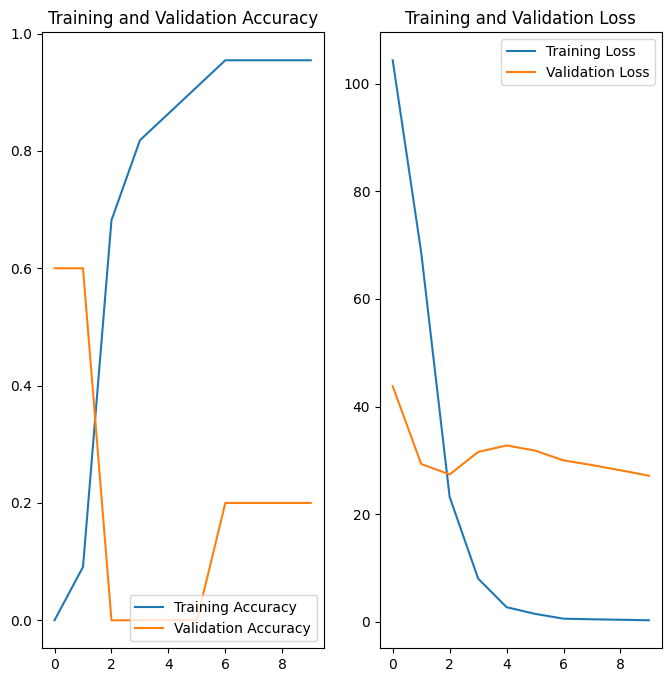

In [87]:
# Train model
epochs = 10
history = model.fit(train_ds, validation_data=valid_ds, epochs=epochs)

# Visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Test the model
# TODO: Build a bigger data set
test_path = Path('./test1.png')
img = tf.keras.utils.load_img(test_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print("This image most likely is {} with a {:.2f} percent confidence".format(class_names[np.argmax(score)], 100 * np.max(score)))
img

In [ ]:
# TODO: Save the model